# Comparison

This notebook will compare E to B leakage generated by the pure Cl calculation and the spice Cl calculation.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as H
import pylab as pl

import cmb_analysis.powerspectrum.pyspice as pyspice
import cmb_analysis.powerspectrum.healpy_ext as H_ext

Populating the interactive namespace from numpy and matplotlib


## Mask and Window

These two functions are just used to create a mask/window used in the calculation instead of reading in a file.

In [3]:
def construct_mask_disc(nside, rad):

    npix = H.nside2npix(nside)

    mask = np.zeros(npix)

    ipix = np.arange(npix)

    vec = np.array(H.pix2vec(nside, ipix))

    ctheta = vec[0, :]*1.0 + vec[1, :]*0.0 + vec[2, :]*0.0
    theta = np.degrees(np.arccos(ctheta))

    idx = theta <= rad
    mask[idx] = 1.0

    return mask


def apodize_mask(mask, delta_c):

    npix = len(mask)
    nside = H.npix2nside(npix)

    ipix = np.arange(npix)
    vec = np.array(H.pix2vec(nside, ipix))


    apodized_mask = 1.0*mask

    good_pix = np.where(mask == 1)[0]
    bad_pix = mask == 0

    vec_bad = vec[:, bad_pix]

    for tmp in good_pix:
        vec_good = vec[:, tmp]
        ctheta = vec_bad[0, :]*vec_good[0] + vec_bad[1, :]*vec_good[1] + vec_bad[2, :]*vec_good[2]
        ctheta[ctheta > 1] = 1.0
        ctheta[ctheta < -1] = -1.0
        theta = np.arccos(ctheta)
        delta_i = np.degrees(np.min(theta))
        if delta_i <= delta_c:
            apodized_mask[tmp] = -1.0 / (2*np.pi) * np.sin(2*np.pi*delta_i / delta_c) + delta_i / delta_c
           
    return apodized_mask

In [11]:
def compare_cl(window, nsims=1, theta=20.0):

    nside = 64

    fn_cl = 'testcl.fits'
    cls = H.read_cl(fn_cl)
    
    cls_spice = None
    cls_pure = None
    cls_anafast = None
    for i in range(nsims):
        #print i, nsims
        testmap = H.synfast(cls, nside, new=True, verbose=False)
        
        ap_maps = (testmap[0]*window, testmap[1]*window, testmap[2]*window)

        cls_tmp = pyspice.spice(testmap, window=window, thetamax=theta, apodizesigma=theta, decouple=True)
        cls_tmp2 = H.anafast(ap_maps)
        cls_tmp3 = H_ext.pureanafast(testmap, window)

        if cls_spice is None:
            cls_spice = cls_tmp
        else:
            cls_spice[0] += cls_tmp[0]
            cls_spice[1] += cls_tmp[1]
            cls_spice[2] += cls_tmp[2]
            cls_spice[3] += cls_tmp[3]

        if cls_anafast is None:
            cls_anafast = cls_tmp2
        else:
            cls_anafast[0] += cls_tmp2[0]
            cls_anafast[1] += cls_tmp2[1]
            cls_anafast[2] += cls_tmp2[2]
            cls_anafast[3] += cls_tmp2[3]
            
        if cls_pure is None:
            cls_pure = cls_tmp3
        else:
            cls_pure[0] += cls_tmp3[0]
            cls_pure[1] += cls_tmp3[1]
            cls_pure[2] += cls_tmp3[2]
            cls_pure[3] += cls_tmp3[3]

        
    cls_spice[0] /= nsims
    cls_spice[1] /= nsims
    cls_spice[2] /= nsims
    cls_spice[3] /= nsims

    cls_anafast[0] /= nsims
    cls_anafast[1] /= nsims
    cls_anafast[2] /= nsims
    cls_anafast[3] /= nsims
    
    cls_pure[0] /= nsims
    cls_pure[1] /= nsims
    cls_pure[2] /= nsims
    cls_pure[3] /= nsims
    
    #Since the Spice code corrects for the effect of the window/apodization of correlation function on
    #the amplitude of the Cl, we need to apply this approximate scaling correction in order to get a 
    #rough comparison between these calculations.
    scaling = cls[0][100] / cls_anafast[0][100]
    scaling2 = cls[0][100] / cls_pure[0][100]
    
    cls_anafast[0] *= scaling
    cls_anafast[1] *= scaling
    cls_anafast[2] *= scaling
    cls_anafast[3] *= scaling
    
    cls_pure[0] *= scaling2
    cls_pure[1] *= scaling2
    cls_pure[2] *= scaling2
    cls_pure[3] *= scaling2

    pl.figure()
    pl.loglog(cls[0], 'k', label='Input')
    pl.loglog(cls[1], 'k')
    pl.loglog(cls[2], 'k')
    pl.loglog(np.abs(cls[3]), 'k')
    pl.loglog(cls_anafast[0], 'b', label='Anafast')
    pl.loglog(cls_anafast[1], 'b')
    pl.loglog(cls_anafast[2], 'b')
    pl.loglog(np.abs(cls_anafast[3]), 'b')
    pl.loglog(cls_spice[0], 'g', label='Spice')
    pl.loglog(cls_spice[1], 'g')
    pl.loglog(cls_spice[2], 'g')
    pl.loglog(np.abs(cls_spice[3]), 'g')
    pl.loglog(cls_pure[0], 'r', label='Pure Cl')
    pl.loglog(cls_pure[1], 'r')
    pl.loglog(cls_pure[2], 'r')
    pl.loglog(np.abs(cls_pure[3]), 'r')
    pl.legend(loc=0, prop={'size': 12})

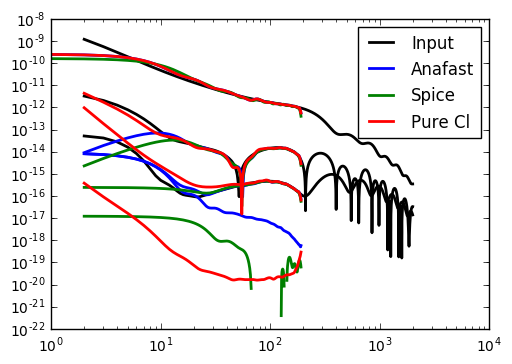

In [12]:
mask = construct_mask_disc(64, 20.0)
window = apodize_mask(mask, 10.0)
compare_cl(window, nsims=20, theta=20.0)